In [5]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import morphology, filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm  # 导入tqdm库
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, \
    Flatten, Dropout, DepthwiseConv2D
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
NUM = 14

In [7]:
import tensorflow as tf

url = "https://file.liux.pro/mnist14.zip"
dataset_dir = tf.keras.utils.get_file("mnist14.zip", url, cache_dir=".", cache_subdir="dataset", extract=True)

103652901/103652901 [==============================] - 62s 1us/step


In [8]:
# 定义数据集路径
data_folder = 'dataset/mnist14'
x_data = []
y_data = []
x_data_original = []  # 用于存储原始图像


# 定义细化处理函数
def thin_image(image):
    binary_image = image > filters.threshold_otsu(image)
    skeleton = morphology.skeletonize(binary_image)
    thin_image = (skeleton * 255).astype(np.uint8)
    return thin_image


def resize_with_black_border(image, ratioX, ratioY):
    # 获取原始图像大小
    original_width, original_height = image.size

    # 根据比例计算缩放后的尺寸
    new_width = int(original_width * ratioX)
    new_height = int(original_height * ratioY)

    # 缩小图像
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # 创建一个黑色背景的新图像，大小与原图相同
    new_image = Image.new('L', (original_width, original_height), color=0)  # 'L' 模式为灰度图

    # 将缩小后的图像粘贴到黑色背景的中央
    left = (original_width - new_width) // 2
    top = (original_height - new_height) // 2
    new_image.paste(resized_image, (left, top))

    return new_image


# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []
    original_images = []

    # 使用tqdm显示进度条
    for img_name in tqdm(os.listdir(label_folder), desc=f'Loading images for label {label}'):
        img_path = os.path.join(label_folder, img_name)

        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小
        if label == 0:
            image = resize_with_black_border(image, 0.7, 0.9)

        image_array = np.array(image)

        # 存储原始图像
        original_images.append(image_array)

        # 细化处理
        image_array = thin_image(image_array)

        images.append(image_array)

    x_data.extend(images)
    y_data.extend([label] * len(images))
    x_data_original.extend(original_images)

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data_original = np.array(x_data_original)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# 创建一个ImageDataGenerator实例并设置增强参数
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=(0.8, 1.0),
    width_shift_range=0.1,
    height_shift_range=0.1
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


Loading images for label 13: 100%|██████████| 4234/4234 [00:04<00:00, 1016.98it/s]


每种图片数量:
类别 0: 11875 张
类别 1: 13533 张
类别 2: 11984 张
类别 3: 12215 张
类别 4: 11622 张
类别 5: 10875 张
类别 6: 11875 张
类别 7: 12496 张
类别 8: 11741 张
类别 9: 11784 张
类别 10: 5059 张
类别 11: 6500 张
类别 12: 5102 张
类别 13: 4234 张


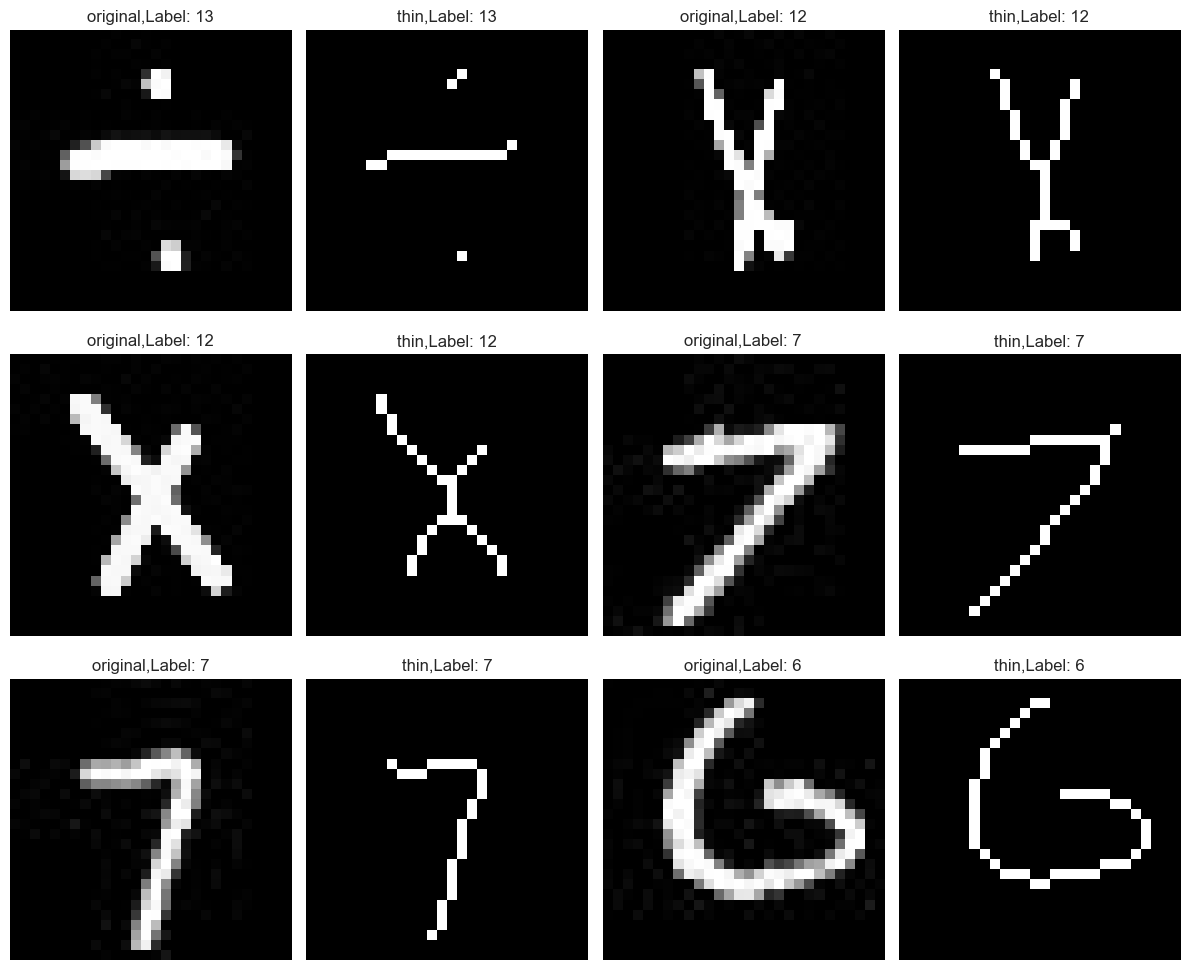

In [9]:
# 显示几个原始图像与细化后的对比图
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# 显示几个样本
for i in range(3):
    for j in range(2):
        idx = np.random.choice(len(x_data))  # 随机选择一个索引
        axes[i, j * 2].imshow(x_data_original[idx], cmap='gray')
        axes[i, j * 2].set_title(f"original,Label: {y_balanced[idx]}")
        axes[i, j * 2].axis('off')

        axes[i, j * 2 + 1].imshow(x_data[idx], cmap='gray')
        axes[i, j * 2 + 1].set_title(f"thin,Label: {y_balanced[idx]}")
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# (x_train,y_train), (x_test,y_test) = mnist.load_data() 

In [11]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) / 255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) / 255

y_train = to_categorical(y_train, num_classes=NUM)
y_test = to_categorical(y_test, num_classes=NUM)

In [12]:
def init_model(dim0):
    model = Sequential()

    # 第一个卷积层
    model.add(Conv2D(dim0 * 8, (3, 3), padding='same', strides=(2, 2),
                     input_shape=(28, 28, 1), name='ftr0a'))
    model.add(BatchNormalization(name="bn0"))
    model.add(Activation('relu', name="relu0"))
    model.add(Dropout(0.3))  # 添加 Dropout 层

    # # 第一个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', name='ftr0b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu00"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    # 第二个卷积层
    model.add(Conv2D(dim0 * 4, (3, 3), padding='same', strides=(2, 2), name='ftr1a'))
    model.add(BatchNormalization(name="bn1"))
    model.add(Activation('relu', name="relu1"))

    # # 第二个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', depth_multiplier=2, name='ftr1b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu11"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    # # 全局平均池化层
    # model.add(GlobalAveragePooling2D(name='GAP'))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    model.add(Flatten())

    # 全连接层
    model.add(Dense(16, name="fc1"))
    model.add(Activation('softmax', name="sm1"))
    model.add(Dropout(0.3))  # 添加 Dropout 层

    # 全连接层
    model.add(Dense(NUM, name="fc2"))
    model.add(Dropout(0.3))  # 添加 Dropout 层
    model.add(Activation('softmax', name="sm2"))

    return model


# 设置参数并初始化模型
DIM0 = 3
model = init_model(DIM0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ftr0a (Conv2D)              (None, 14, 14, 24)        240       
                                                                 
 bn0 (BatchNormalization)    (None, 14, 14, 24)        96        
                                                                 
 relu0 (Activation)          (None, 14, 14, 24)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 24)        0         
                                                                 
 ftr1a (Conv2D)              (None, 7, 7, 12)          2604      
                                                                 
 bn1 (BatchNormalization)    (None, 7, 7, 12)          48        
                                                                 
 relu1 (Activation)          (None, 7, 7, 12)          0

In [ ]:
# 编译模型
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])

# 创建数据增强生成器
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# 使用数据生成器进行训练，并获取 History 对象
history = model.fit(train_generator,
                    batch_size=1280,
                    epochs=30,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle=True)

# 加载最佳模型权重
model.load_weights('best_model.h5')


# 绘制训练和验证的损失和准确率曲线
def plot_training_history(history):
    # 绘制训练 & 验证损失值
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # 绘制训练 & 验证准确率值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()


plot_training_history(history)


Epoch 1/30


In [ ]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM), yticklabels=range(NUM))
plt.xlabel('predict')
plt.ylabel('real')
plt.title('Confusion matrix')
plt.show()


In [ ]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


In [ ]:
# 导出模型
# model.save("mnist.h5")
model.export("mnist")
# 调用转换脚本
!python tools/h5_to_tflite.py mnist mnist.tflite 1 dataset/mnist14  0to1
!python tools/tflite2tmdl.py mnist.tflite mnist.tmdl int8 1 28,28,1 14 1